# 🚲 **Analyzing Bikeshare Trends and Usage Patterns (2015–2017)**
#### By Shane Fitzpatrick
#### www.linkedin.com/in/shane-fitzpatrick-68030b26 


Bikeshare systems continue to reshape urban mobility, and New York City’s Citi Bike program is a prime example. Between 2015 and 2017, ridership soared, reflecting both growing commuter acceptance and city-wide sustainability initiatives. This project takes an in-depth look at three years of Citi Bike data to uncover **when**, **where**, and **how** people use bikeshare services, with an eye toward guiding operational improvements and policy decisions.

## **Project Overview**
- **Objective**: Identify key factors affecting bikeshare usage—such as time of day, day of the week, and station demand—and translate these findings into actionable recommendations for stakeholders (e.g., operators, city planners, potential investors).
- **Data Source**: This analysis uses publicly available trip data from Citi Bike, obtained in a curated format from Kaggle (covering 2015–2017). It includes details on trip duration, start/end stations, timestamps, and user types.
- **Approach**:  
  1. **Data Wrangling** – Clean and format the raw dataset to handle missing values and align station information.  
  2. **Exploratory Analysis** – Visualize ridership patterns over time, by station, and by user segments to spotlight peak usage and geographic trends.  
  3. **Modeling** – Use regression techniques to investigate which features (e.g., location, time, season) best predict bikeshare demand.  
  4. **Recommendations** – Propose ways to optimize station placement, balance bike inventory, and inform marketing strategies.

---

## Packages & Importing Dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import gdown

In [2]:
# gdown for easy data access
#!pip install gdown #can comment if already installed

#link to dataset-- uploaded to my google drive
url = 'https://drive.google.com/uc?export=download&id=1XlCnpIt-_A6kIIUhTpIUh_uwfk4xx1Mm'
output = 'NYC-BikeShare-2015-2017-combined.csv'
gdown.download(url, output, quiet=False)

df = pd.read_csv(output)
print(df.head())

Downloading...
From (original): https://drive.google.com/uc?export=download&id=1XlCnpIt-_A6kIIUhTpIUh_uwfk4xx1Mm
From (redirected): https://drive.google.com/uc?export=download&id=1XlCnpIt-_A6kIIUhTpIUh_uwfk4xx1Mm&confirm=t&uuid=89e5cae7-61e8-4a41-8766-b93e2f6e449a
To: /Users/shanefitzpatrick/Bikeshare project/NYC-BikeShare-2015-2017-combined.csv
100%|██████████| 132M/132M [00:02<00:00, 44.2MB/s] 


   Unnamed: 0  Trip Duration           Start Time            Stop Time  \
0           0            376  2015-10-01 00:16:26  2015-10-01 00:22:42   
1           1            739  2015-10-01 00:27:12  2015-10-01 00:39:32   
2           2           2714  2015-10-01 00:32:46  2015-10-01 01:18:01   
3           3            275  2015-10-01 00:34:31  2015-10-01 00:39:06   
4           4            561  2015-10-01 00:40:12  2015-10-01 00:49:33   

   Start Station ID Start Station Name  Start Station Latitude  \
0              3212    Christ Hospital               40.734786   
1              3207        Oakland Ave               40.737604   
2              3193       Lincoln Park               40.724605   
3              3199       Newport Pkwy               40.728745   
4              3183     Exchange Place               40.716247   

   Start Station Longitude  End Station ID    End Station Name  \
0               -74.050444            3207         Oakland Ave   
1               -74.052478

In [3]:
bikeshare = df.copy()

### **1. Station Demand Dynamics**
- **High Net Inflow Stations:** Stations like Grove St PATH and Exchange Place show significantly higher net inflow, indicating they're popular endpoints—likely driven by commuting patterns and proximity to major transport hubs.  
- **Net Outflow Stations:** Stations with large negative net flows suggest popular departure points, possibly residential neighborhoods or areas with fewer transit connections.  
- These patterns offer clear opportunities to balance bike availability through strategic bike repositioning or infrastructure investments.

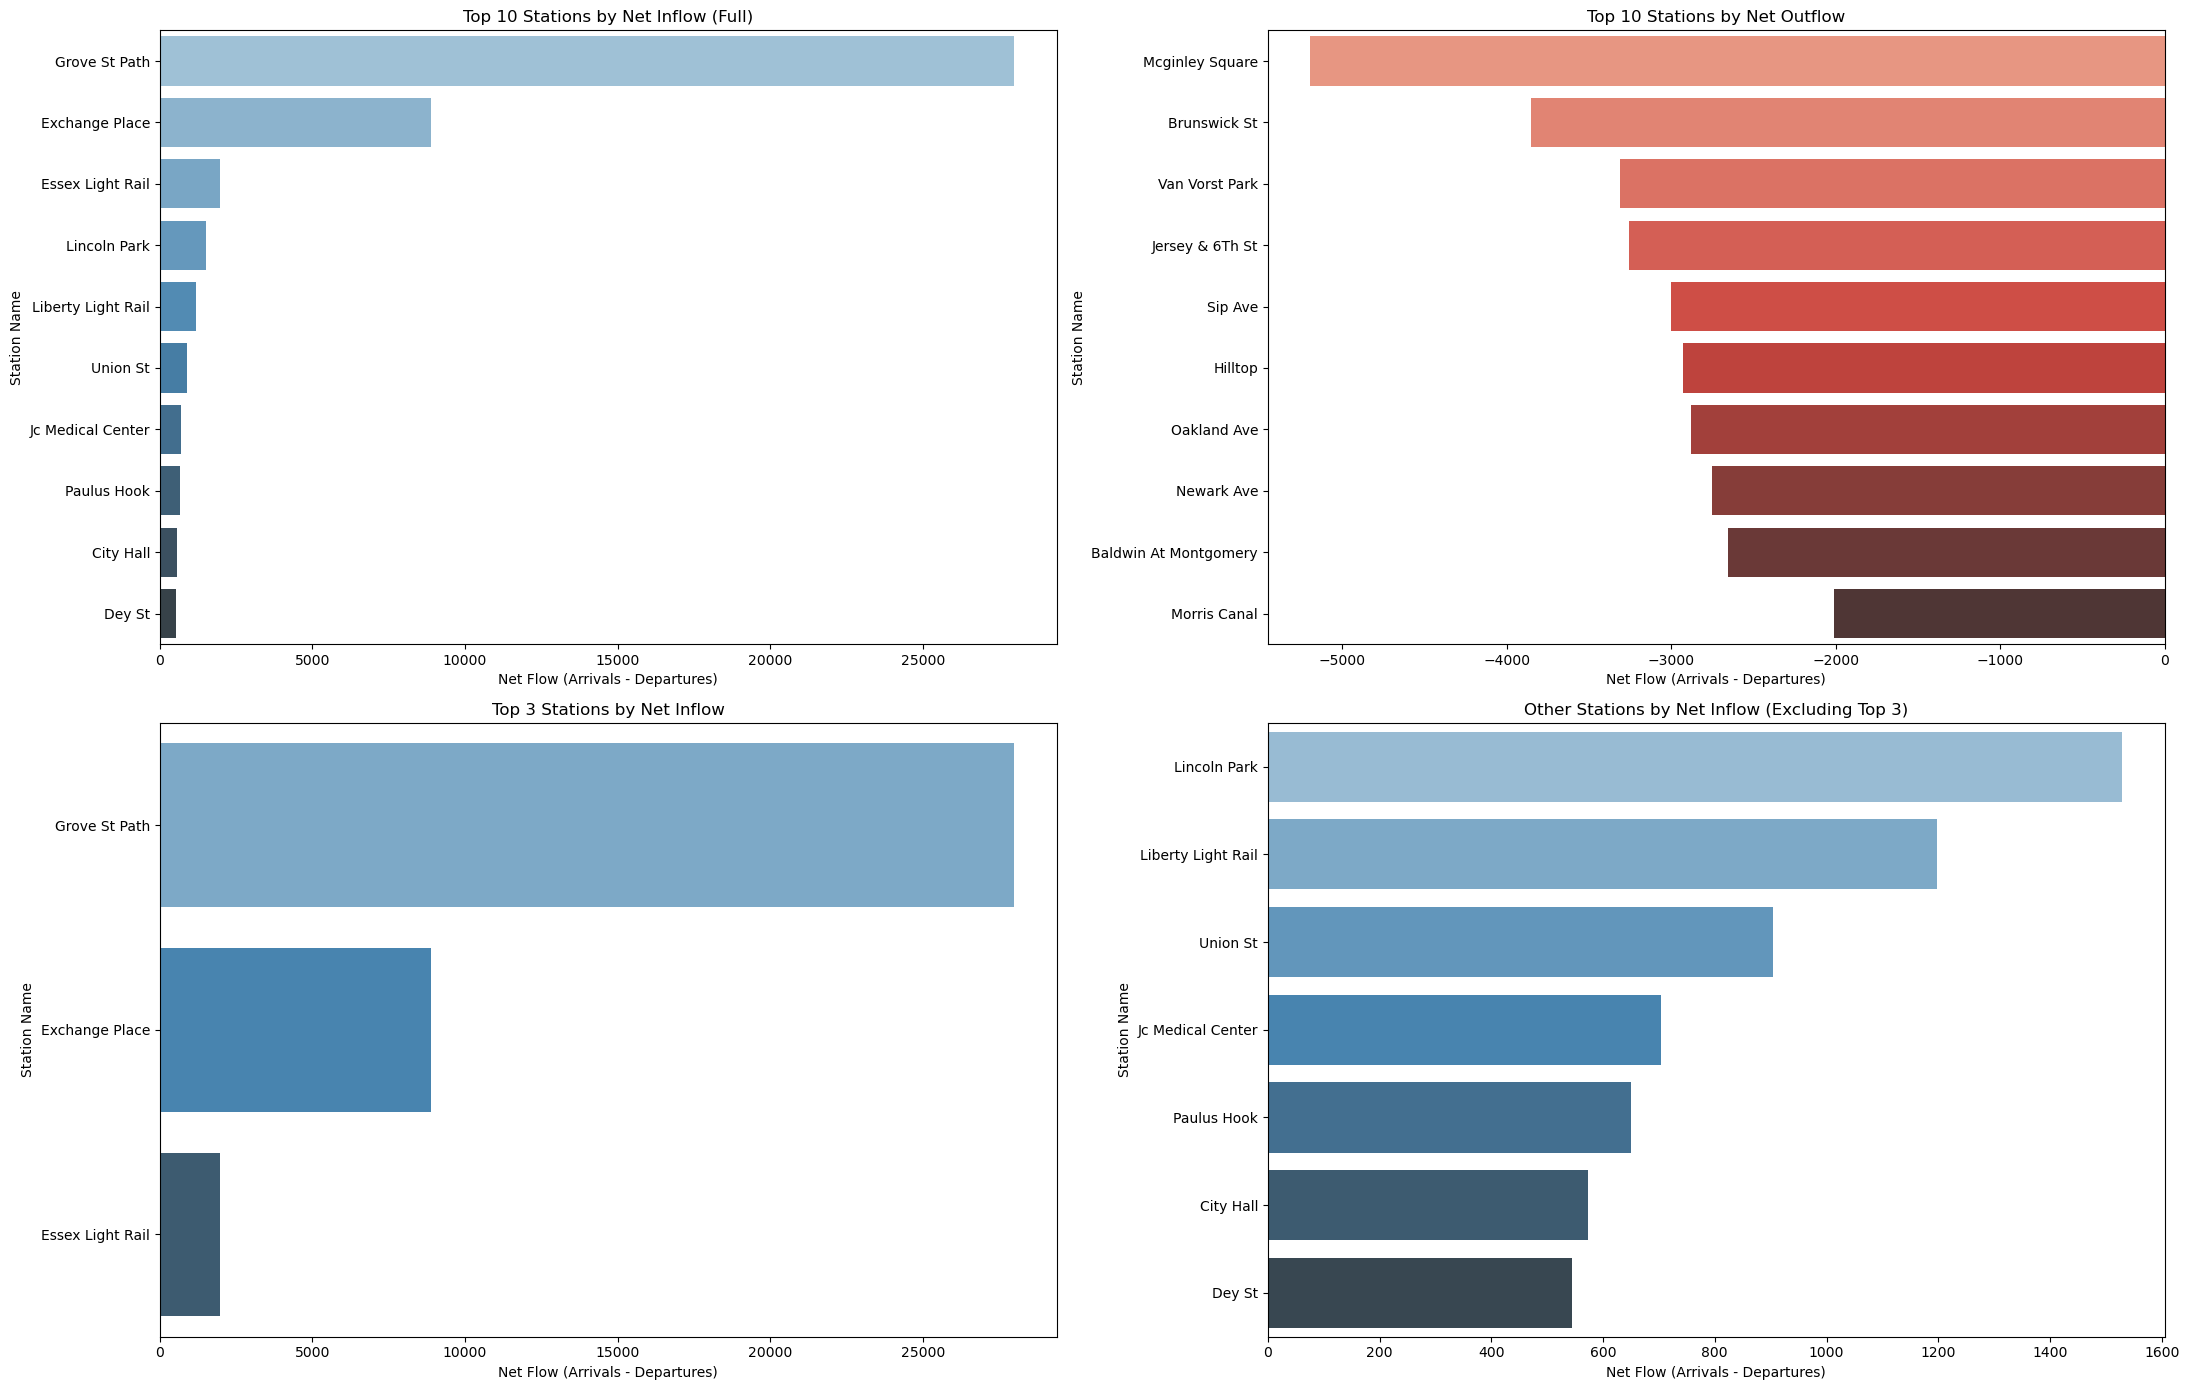

In [4]:
# Quick cleanup: trim and format station names for consistency
bikeshare['Start Station Name'] = bikeshare['Start Station Name'].str.strip().str.title()
bikeshare['End Station Name'] = bikeshare['End Station Name'].str.strip().str.title()

# Count trips starting and ending at each station
starts = bikeshare['Start Station Name'].value_counts()
ends = bikeshare['End Station Name'].value_counts()

# Merge counts into one df, fill gaps
flow_data = pd.concat([
    starts.rename('Departures'),
    ends.rename('Arrivals')
], axis=1).fillna(0)

# Compute net flow (positive = inflow station)
flow_data['Net Flow'] = flow_data['Arrivals'] - flow_data['Departures']

# Reset index so we can access station names as a column
flow_data = flow_data.reset_index().rename(columns={'index': 'Station Name'})

# Sort by net flow, descending
flow_sorted = flow_data.sort_values('Net Flow', ascending=False)

# Top/bottom station breakdowns
inflow_top10 = flow_sorted.head(10)
inflow_top3 = inflow_top10.iloc[:3]
inflow_rest = inflow_top10.iloc[3:]

outflow_top10 = flow_sorted.sort_values('Net Flow').head(10)

# Plotting setup (2x2 grid)
fig, axes = plt.subplots(2, 2, figsize=(22, 14))

# Top-left: all top 10 inflow
sns.barplot(data=inflow_top10, x='Net Flow', y='Station Name', ax=axes[0, 0], palette='Blues_d')
axes[0, 0].set_title('Top 10 Stations by Net Inflow (Full)')
axes[0, 0].set_xlabel('Net Flow (Arrivals - Departures)')

# Top-right: top 10 outflow
sns.barplot(data=outflow_top10, x='Net Flow', y='Station Name', ax=axes[0, 1], palette='Reds_d')
axes[0, 1].set_title('Top 10 Stations by Net Outflow')
axes[0, 1].set_xlabel('Net Flow (Arrivals - Departures)')

# Bottom-left: top 3 inflow
sns.barplot(data=inflow_top3, x='Net Flow', y='Station Name', ax=axes[1, 0], palette='Blues_d')
axes[1, 0].set_title('Top 3 Stations by Net Inflow')
axes[1, 0].set_xlabel('Net Flow (Arrivals - Departures)')

# Bottom-right: next 7 inflow (excluding top 3)
sns.barplot(data=inflow_rest, x='Net Flow', y='Station Name', ax=axes[1, 1], palette='Blues_d')
axes[1, 1].set_title('Other Stations by Net Inflow (Excluding Top 3)')
axes[1, 1].set_xlabel('Net Flow (Arrivals - Departures)')

plt.tight_layout()
plt.show()

### **2. Temporal Usage Patterns**
- **Daily Trips Analysis:** Daily usage visualization with a 7-day moving average highlights clear seasonal trends. Summer months see significantly increased ridership, suggesting weather and tourism as strong influencing factors.  
- **Monthly Usage Breakdown:** Monthly data reveals a cyclical pattern with peak ridership in warmer months (May through October), underscoring the impact of weather and seasonal activities on consumer behavior.

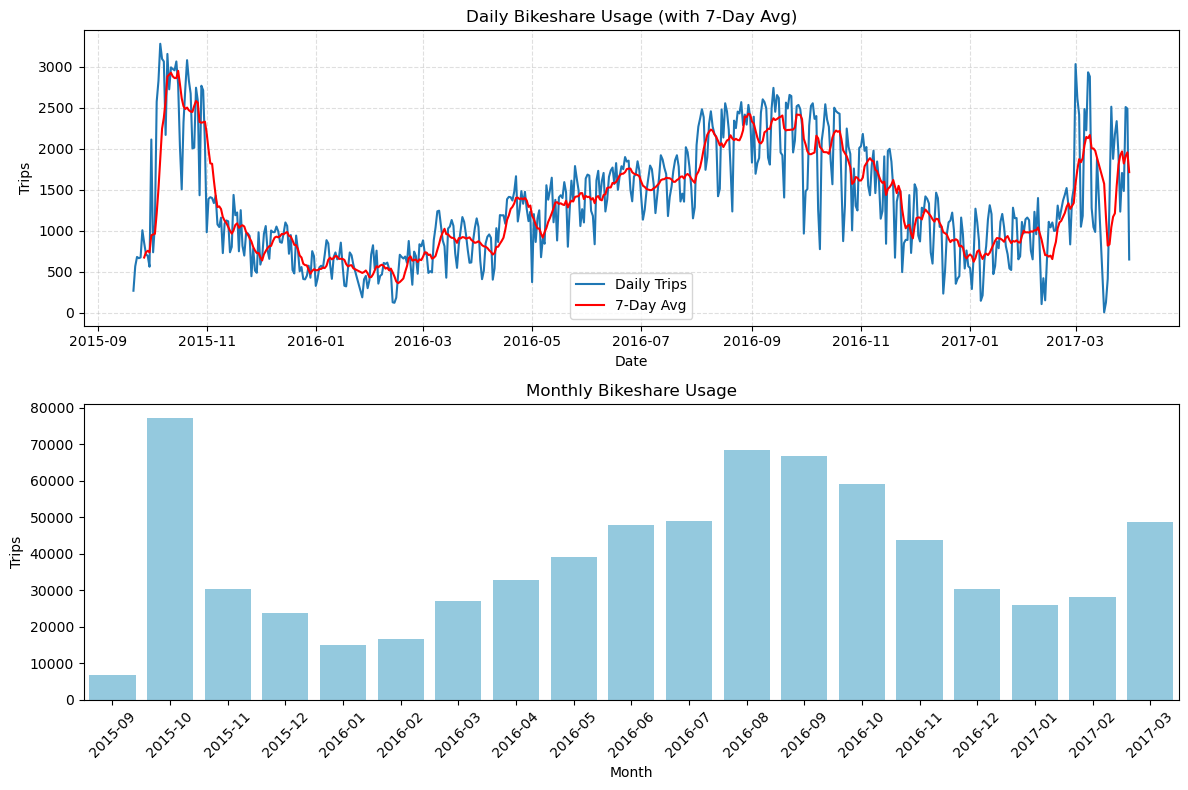

In [5]:
# Convert start time to datetime and drop bad rows
bikeshare["Start Time"] = pd.to_datetime(bikeshare["Start Time"], errors="coerce")
bikeshare = bikeshare.dropna(subset=["Start Time"])

# Daily trip counts
bikeshare["Date"] = bikeshare["Start Time"].dt.date
daily_counts = bikeshare.groupby("Date").size()

# Put into a DataFrame for plotting
daily_df = pd.DataFrame({
    "Date": pd.to_datetime(daily_counts.index),
    "Trips": daily_counts.values
}).sort_values("Date")

# Add 7-day rolling average
daily_df["7d_avg"] = daily_df["Trips"].rolling(7).mean()

# Monthly usage
monthly = bikeshare.groupby(bikeshare["Start Time"].dt.to_period("M")).size()
monthly.index = monthly.index.to_timestamp()
month_labels = monthly.index.strftime("%Y-%m")

# Plot both daily and monthly usage
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Daily line chart
sns.lineplot(data=daily_df, x="Date", y="Trips", ax=axes[0], label="Daily Trips")
sns.lineplot(data=daily_df, x="Date", y="7d_avg", ax=axes[0], label="7-Day Avg", color="red")
axes[0].set_title("Daily Bikeshare Usage (with 7-Day Avg)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Trips")
axes[0].grid(True, linestyle="--", alpha=0.4)

# Monthly bar chart
sns.barplot(x=month_labels, y=monthly.values, ax=axes[1], color="skyblue")
axes[1].set_title("Monthly Bikeshare Usage")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Trips")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### **3. User Type Analysis: Subscribers vs. Customers**
- Subscribers overwhelmingly dominate daily usage, maintaining consistent ridership throughout weekdays.  
- Casual customers exhibit notable spikes in ridership during weekends, presenting a clear opportunity for targeted incentives to convert these occasional users into subscribers.


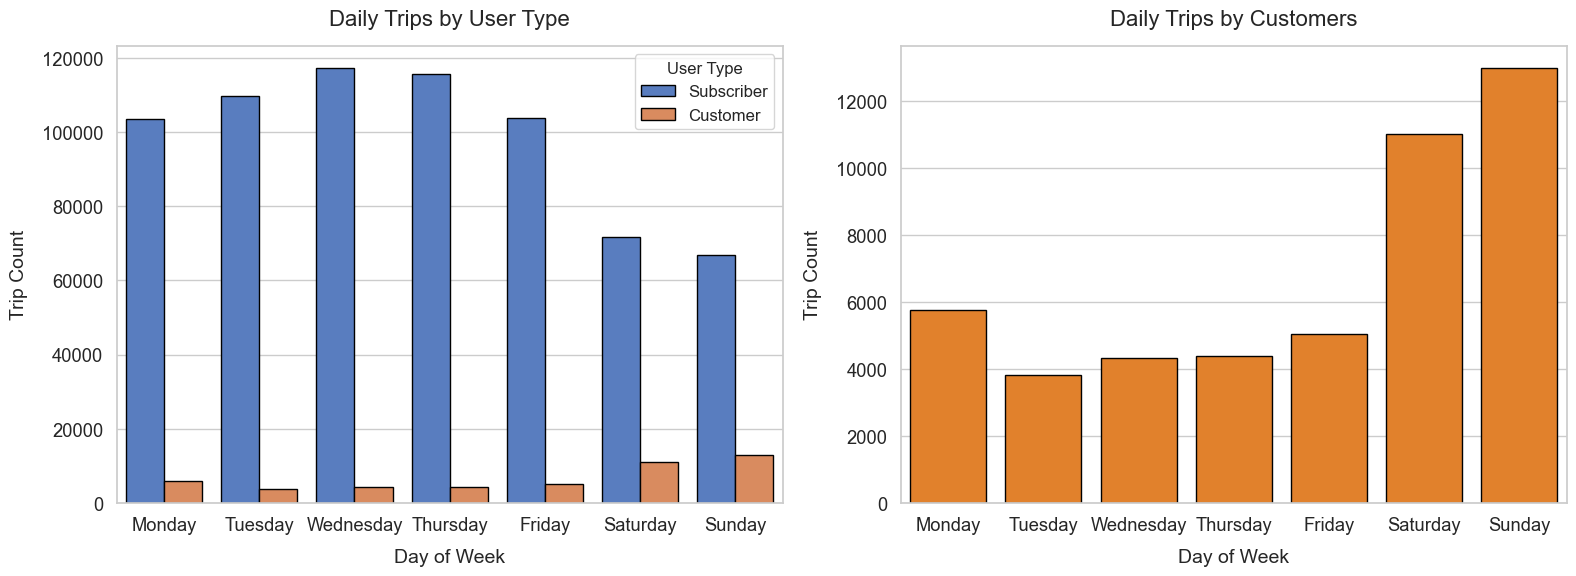

In [9]:
sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

# Ensure 'Start Time' is datetime and create a DayOfWeek column
bikeshare["Start Time"] = pd.to_datetime(bikeshare["Start Time"], errors="coerce")
bikeshare["DayOfWeek"] = bikeshare["Start Time"].dt.day_name()

# Define the week order
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# left plot: overall daily trips by user type
sns.countplot(data=bikeshare, x="DayOfWeek", hue="User Type", order=day_order, ax=axes[0], edgecolor="black")

axes[0].set_title("Daily Trips by User Type", fontsize=16, pad=15)
axes[0].set_xlabel("Day of Week", fontsize=14, labelpad=10)
axes[0].set_ylabel("Trip Count", fontsize=14, labelpad=10)
axes[0].legend(title="User Type", title_fontsize=12, fontsize=12, loc="upper right")
axes[0].tick_params(axis="x", labelrotation=0)

# right plot: daily trips for customers only, better visualize weekend spike
bikeshare_customers = bikeshare[bikeshare["User Type"] == "Customer"]
sns.countplot(data=bikeshare_customers, x="DayOfWeek", order=day_order, ax=axes[1], color="#ff7f0e", edgecolor="black")
axes[1].set_title("Daily Trips by Customers", fontsize=16, pad=15)
axes[1].set_xlabel("Day of Week", fontsize=14, labelpad=10)
axes[1].set_ylabel("Trip Count", fontsize=14, labelpad=10)
axes[1].tick_params(axis="x", labelrotation=0)

plt.tight_layout()
plt.show()

## 4. **Ridership Patterns: Hourly and Daily Trends**

Analysis of bikeshare usage by day and hour reveals clear trends:
- **Weekdays:** High consistent usage, with pronounced commuter peaks around **8 AM and 5–6 PM**. Bike availability should be prioritized during these weekday rush hours.
- **Weekends:** Lower overall ridership, more evenly distributed across daytime hours, indicating leisure or tourism use. Leisure-focused campaigns could be promoted on weekends to boost ridership.

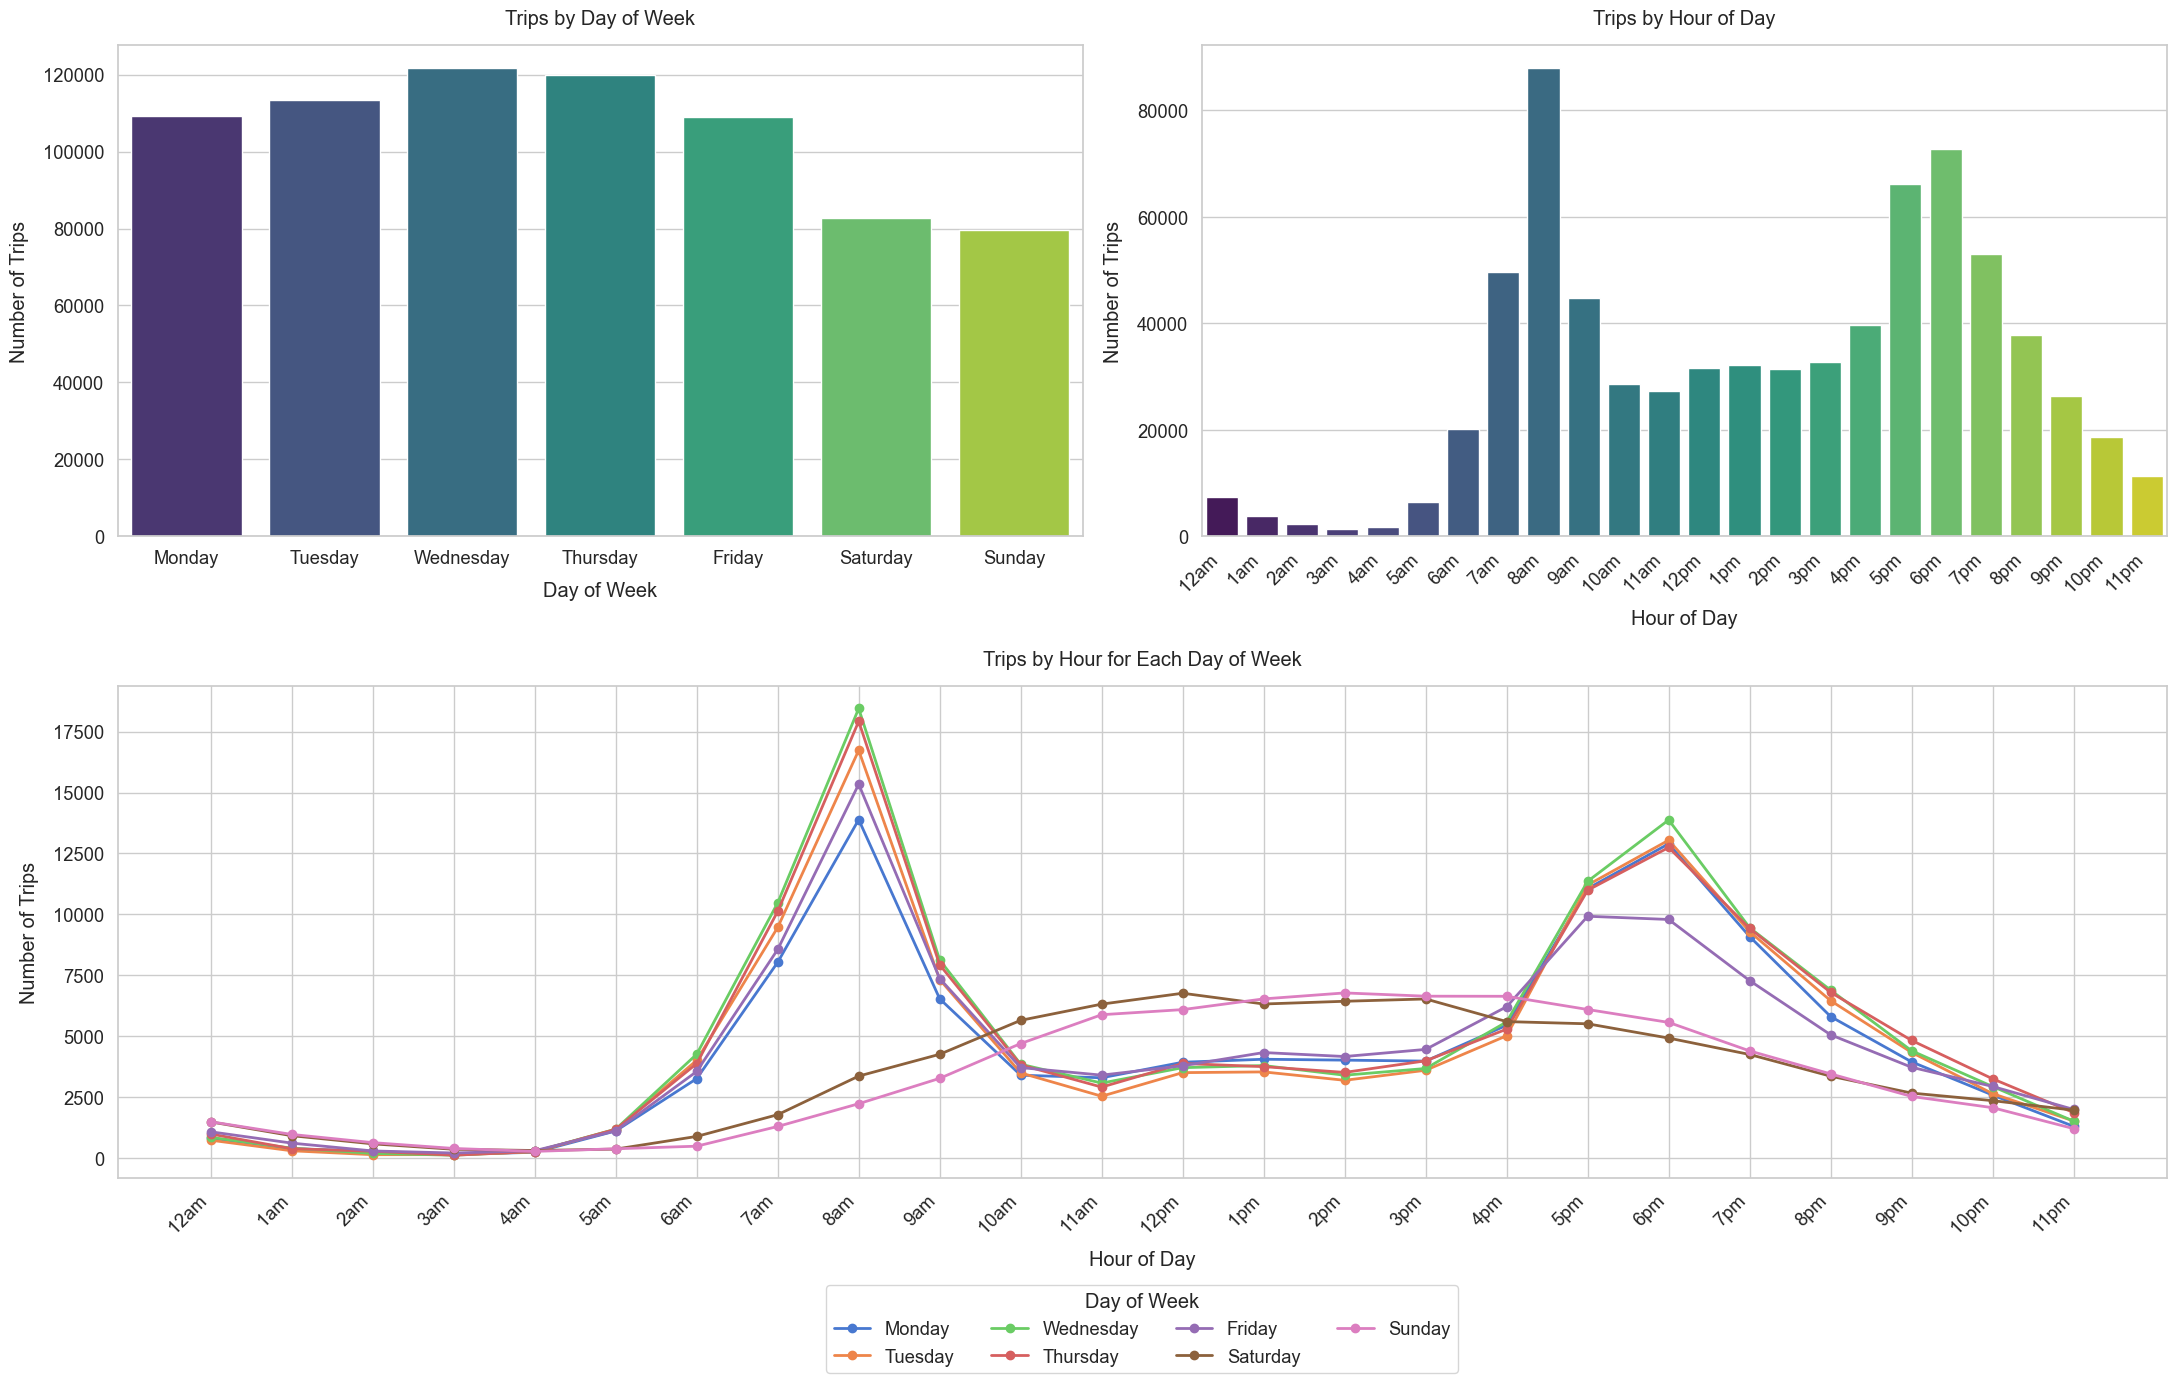

In [12]:
# Convert "Start Time" to datetime and extract hour + weekday info
bikeshare["Start Time"] = pd.to_datetime(bikeshare["Start Time"], errors="coerce")
bikeshare["Hour"] = bikeshare["Start Time"].dt.hour
bikeshare["DayOfWeek"] = bikeshare["Start Time"].dt.day_name()

# Set up weekday order and hour labels for plots
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
hour_labels_12h = [
    "12am", "1am", "2am", "3am", "4am", "5am", "6am", "7am", "8am", "9am", "10am", "11am",
    "12pm", "1pm", "2pm", "3pm", "4pm", "5pm", "6pm", "7pm", "8pm", "9pm", "10pm", "11pm"
]

# Set up the figure and gridspec layout (2x2, two plots on top, one wide plot on bottom)
fig = plt.figure(figsize=(22, 14))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])  # top left
ax2 = fig.add_subplot(gs[0, 1])  # top right
ax3 = fig.add_subplot(gs[1, :])  # bottom

# Plot 1: Trips by day of week
sns.countplot(data=bikeshare, x="DayOfWeek", order=day_order, palette="viridis", ax=ax1)
ax1.set_title("Trips by Day of Week", pad=15)
ax1.set_xlabel("Day of Week", labelpad=10)
ax1.set_ylabel("Number of Trips", labelpad=10)

# Plot 2: Trips by hour of day
sns.countplot(data=bikeshare, x="Hour", palette="viridis", ax=ax2)
ax2.set_title("Trips by Hour of Day", pad=15)
ax2.set_xlabel("Hour of Day", labelpad=10)
ax2.set_ylabel("Number of Trips", labelpad=10)
ax2.set_xticks(range(24))
ax2.set_xticklabels(hour_labels_12h, rotation=45, ha="right")

# Plot 3: Line plot - hourly trip trends across days
df_line = (bikeshare.groupby(["DayOfWeek", "Hour"]).size().unstack("DayOfWeek").reindex(columns=day_order))
df_line.plot(ax=ax3, marker="o", linewidth=2)
ax3.set_title("Trips by Hour for Each Day of Week", pad=15)
ax3.set_xlabel("Hour of Day", labelpad=10)
ax3.set_ylabel("Number of Trips", labelpad=10)
ax3.set_xticks(range(24))
ax3.set_xticklabels(hour_labels_12h, rotation=45, ha="right")

# Adjust legend to avoid overlap with bottom plot
ax3.legend(title="Day of Week", loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=4)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)
plt.show()


##  **Regression Analysis**
Using geographic coordinates (latitude and longitude) to predict station usage, the regression analysis yielded an adjusted R² of approximately **0.27**. This indicates that while location significantly impacts station usage, explaining about 27% of variability, other factors likely play an essential role. Factors such as nearby amenities, population density, and public transportation links may further enhance predictive accuracy. These variables could be incorporated in subsequent regression models.

In [ ]:
# Standardizing station names for matching later
bikeshare['Start Station Name'] = bikeshare['Start Station Name'].str.strip().str.title()
bikeshare['End Station Name'] = bikeshare['End Station Name'].str.strip().str.title()

# Count number of trips per station (both ends)
start_counts = bikeshare['Start Station Name'].value_counts().rename("Departures")
end_counts = bikeshare['End Station Name'].value_counts().rename("Arrivals")

# Combine into one df to calculate net difference
station_flow = pd.concat([start_counts, end_counts], axis=1).fillna(0)
station_flow['Net Flow'] = station_flow['Departures'] - station_flow['Arrivals']

# Move station names from index to column
station_flow.reset_index(inplace=True)
station_flow.rename(columns={'index': 'Station Name'}, inplace=True)

# Pull lat/lon info from start station fields
coords = bikeshare[['Start Station Name', 'Start Station Latitude', 'Start Station Longitude']].drop_duplicates()

# Merge coordinates in — should be safe after cleaning
station_flow = station_flow.merge(coords, left_on='Station Name', right_on='Start Station Name', how='left')
station_flow.drop(columns='Start Station Name', inplace=True)

# Rename columns for convenience
station_flow.rename(columns={
    'Start Station Latitude': 'lat',
    'Start Station Longitude': 'lon'
}, inplace=True)

# Quick poly regression on spatial features to see if geography predicts departures
import statsmodels.formula.api as smf

model = smf.ols('Departures ~ lat + lon + I(lat**2) + I(lon**2) + I(lat*lon)', data=station_flow).fit()

print("\nPolynomial Model Summary:")
print(model.summary())

## **Recommendations for Strategic Action**
- Implement **weekend-focused promotions** to convert casual riders into subscribers, especially during summer months when casual ridership peaks.  
- Optimize **bike distribution strategies** around high inflow and outflow stations to maintain availability and balance.  
- Develop **seasonal strategies**, such as special events or discounted subscription offers during peak months, to capitalize on increased ridership and improve service satisfaction.

*Through comprehensive data visualization and analysis, this project identifies clear, actionable insights that could meaningfully enhance operational efficiency and user experience in the bikeshare system.*
